In [65]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [66]:

np.random.seed(2298453) 
#
random.seed(2298453)


tf.random.set_seed(2298453)

K.clear_session() # Set seed for Keras

In [67]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [68]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [69]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [70]:
# Define client functions
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, 
              #verbose=0,
             verbose=1)
    return model

In [71]:
# Split data into two clients
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, 
                                                                  #random_state=42,
                                                  # Put your SID instead of number '42'                
                                                                  random_state= 2167288
                                                                 )

In [72]:
print(x_train_c1.shape)
print(x_train_c2.shape)
print(y_train_c1.shape)
print(y_train_c2.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000,)
(30000,)


In [73]:
# Create and train client models

client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)

Epoch 1/5
938/938 [==============================] - 3s 2ms/step - loss: 0.3436 - accuracy: 0.9036
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1656 - accuracy: 0.9516
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1148 - accuracy: 0.9667
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0857 - accuracy: 0.9746
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0648 - accuracy: 0.9813
Epoch 1/5
938/938 [==============================] - 3s 2ms/step - loss: 0.3497 - accuracy: 0.8994
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1614 - accuracy: 0.9532
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1125 - accuracy: 0.9669
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0821 - accuracy: 0.9766
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0636 - accuracy: 0.9812


In [74]:
# Federated averaging

def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [75]:
# Aggregate models

aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [76]:
# Create global model and set weights

global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [77]:
# Evaluate global model

test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 0.4197 - accuracy: 0.8764 - 720ms/epoch - 2ms/step
Test accuracy: 0.8763999938964844


In [78]:
test_accuracy = []

In [79]:
test_accuracy.append(0.8851000070571899)

In [80]:
test_accuracy

[0.8851000070571899]

In [81]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [82]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 1ms/step
(10000, 10)


In [83]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       980
           1       0.95      0.86      0.90      1135
           2       0.78      0.96      0.86      1032
           3       0.75      0.95      0.83      1010
           4       0.97      0.89      0.93       982
           5       0.82      0.94      0.88       892
           6       0.98      0.87      0.92       958
           7       0.82      0.95      0.88      1028
           8       0.95      0.57      0.71       974
           9       0.92      0.85      0.88      1009

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.87     10000
weighted avg       0.89      0.88      0.87     10000



In [84]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

Accuracy test set:  0.8764
Precision test set:  0.8904988373043096
Recall test set:  0.8764
F-score test set:  0.8748186111855937


In [85]:
test_precision = []
test_recall    = []
test_f1_score  = []

In [86]:
test_precision.append(0.907323157047967)
test_recall.append(0.8851)
test_f1_score.append(0.8851514824563385)

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

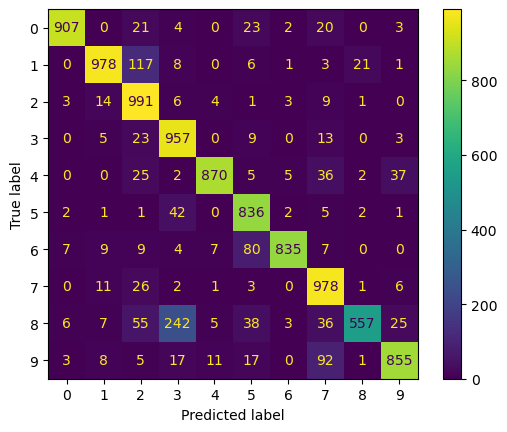

In [88]:
# display confusion matrix between test output and predicted output

cm = confusion_matrix(y_test, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();
#plt.show()

In [89]:
Client_1 = (x_train[0:15000], y_train[0:15000])
Client_2 = (x_train[15000:30000], y_train[15000:30000])
Client_3 = (x_train[30000:45000], y_train[30000:45000])
Client_4 = (x_train[45000:], y_train[45000:])

In [90]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [91]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])

Epoch 1/5
469/469 [==============================] - 2s 2ms/step - loss: 0.4591 - accuracy: 0.8737
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2141 - accuracy: 0.9411
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1502 - accuracy: 0.9565
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1117 - accuracy: 0.9687
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0856 - accuracy: 0.9753
Epoch 1/5
469/469 [==============================] - 3s 2ms/step - loss: 2.3166 - accuracy: 0.1026
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2956 - accuracy: 0.1187
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2866 - accuracy: 0.1317
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2711 - accuracy: 0.1451
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2511 - accuracy: 0.1589
Epoch 1/5


In [92]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2, weights3, weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights

In [93]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [94]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 2.2113 - accuracy: 0.3446 - 684ms/epoch - 2ms/step
Test accuracy: 0.34459999203681946


In [95]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 1ms/step
(10000, 10)


In [96]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

Accuracy test set:  0.3446
Precision test set:  0.38951069332193655
Recall test set:  0.3446
F-score test set:  0.2910442378393783
              precision    recall  f1-score   support

           0       0.31      0.09      0.14       980
           1       0.32      0.95      0.48      1135
           2       0.28      0.04      0.07      1032
           3       0.30      0.09      0.14      1010
           4       0.46      0.25      0.32       982
           5       0.53      0.04      0.08       892
           6       0.69      0.38      0.49       958
           7       0.56      0.65      0.60      1028
           8       0.25      0.17      0.20       974
           9       0.23      0.66      0.34      1009

    accuracy                           0.34     10000
   macro avg       0.39      0.33      0.29     10000
weighted avg       0.39      0.34      0.29     10000



In [97]:
test_accuracy.append(0.28790000081062317)
test_precision.append(0.37310911314701634)
test_recall.append(0.2879)
test_f1_score.append(0.2500357846568731)

In [98]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317]
[0.907323157047967, 0.37310911314701634]
[0.8851, 0.2879]
[0.8851514824563385, 0.2500357846568731]


In [99]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [100]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5072 - accuracy: 0.8637
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.2378 - accuracy: 0.9335
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1764 - accuracy: 0.9490
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1343 - accuracy: 0.9617
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1046 - accuracy: 0.9706
Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 2.3199 - accuracy: 0.1047
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2942 - accuracy: 0.1217
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2792 - accuracy: 0.1393
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2577 - accuracy: 0.1567
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2306 - accuracy: 0.1711
Epoch 1/5


In [101]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [102]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.9551 - accuracy: 0.6399 - 641ms/epoch - 2ms/step
Test accuracy: 0.6399000287055969
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.6399
Precision test set:  0.7560905011039863
Recall test set:  0.6399
F-score test set:  0.6274974004174357
              precision    recall  f1-score   support

           0       0.98      0.66      0.79       980
           1       0.88      0.95      0.92      1135
           2       0.96      0.34      0.51      1032
           3       0.47      0.66      0.55      1010
           4       0.97      0.14      0.25       982
           5       0.44      0.95      0.60       892
           6       0.85      0.64      0.73       958
           7       0.45      0.91      0.60      1028
           8       0.88      0.60      0.71       974
           9       0.65      0.54      0.59      1009

    accuracy                           0.64     10000
   macro avg       0.75      0.64      0.62    

In [103]:
test_accuracy.append(0.7271999716758728)
test_precision.append(0.7834205071021751)
test_recall.append(0.7272)
test_f1_score.append(0.7308748558259915)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751]
[0.8851, 0.2879, 0.7272]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915]


In [104]:
Client_1 = (x_train[0:7500], y_train[0:7500])
Client_2 = (x_train[7500:15000], y_train[7500:15000])
Client_3 = (x_train[15000:22500], y_train[15000:22500])
Client_4 = (x_train[22500:30000], y_train[22500:30000])
Client_5 = (x_train[30000:37500], y_train[30000:37500])
Client_6 = (x_train[37500:45000], y_train[37500:45000])
Client_7 = (x_train[45000:52500], y_train[45000:52500])
Client_8 = (x_train[52500:], y_train[52500:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
Epoch 1/5
235/235 [==============================] - 1s 2ms/step - loss: 0.5671 - accuracy: 0.8471
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.9331
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.9463
Epoch 4/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.9563
Epoch 5/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1150 - accuracy: 0.9691
Epoch 1/5
235/235 [==============================] - 1s 2ms/step - loss: 2.3219 - accuracy: 0.0977
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2878 - accuracy: 0.1273
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2655 - accuracy: 0.1488


In [105]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, 
                              weights5, weights6, weights7, weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2, weights3, weights4, 
                                              weights5, weights6, weights7, weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 +w8) / 8)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [106]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.8334 - accuracy: 0.6902 - 882ms/epoch - 3ms/step
Test accuracy: 0.6901999711990356
313/313 [==============================] - 1s 2ms/step
(10000, 10)
Accuracy test set:  0.6902
Precision test set:  0.7881956601785
Recall test set:  0.6902
F-score test set:  0.6691840208001003
              precision    recall  f1-score   support

           0       0.96      0.16      0.27       980
           1       0.96      0.87      0.91      1135
           2       0.45      0.93      0.60      1032
           3       0.74      0.88      0.81      1010
           4       0.97      0.27      0.42       982
           5       0.72      0.76      0.74       892
           6       0.98      0.59      0.73       958
           7       0.79      0.94      0.86      1028
           8       0.80      0.57      0.67       974
           9       0.50      0.88      0.64      1009

    accuracy                           0.69     10000
   macro avg       0.79      0.68      0.67     10

In [107]:
test_accuracy.append(0.6028000116348267)
test_precision.append(0.7986126719530607)
test_recall.append(0.6028)
test_f1_score.append(0.5536289939655649)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607]
[0.8851, 0.2879, 0.7272, 0.6028]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649]


In [108]:
Client_1 = (x_train[0:6000], y_train[0:6000])
Client_2 = (x_train[6000:12000], y_train[6000:12000])
Client_3 = (x_train[12000:18000], y_train[12000:18000])
Client_4 = (x_train[18000:24000], y_train[18000:24000])
Client_5 = (x_train[24000:30000], y_train[24000:30000])
Client_6 = (x_train[30000:36000], y_train[30000:36000])
Client_7 = (x_train[36000:42000], y_train[36000:42000])
Client_8 = (x_train[42000:48000], y_train[42000:48000])
Client_9 = (x_train[48000:54000], y_train[48000:54000])
Client_10 = (x_train[54000:], y_train[54000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)
print(Client_9[0].shape)
print(Client_10[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)
print(Client_9[1].shape)
print(Client_10[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])
client9_model = train_client_model(client9_model, Client_9[0], Client_9[1])
client10_model = train_client_model(client10_model, Client_10[0], Client_10[1])

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 0.6370 - accuracy: 0.8260
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2787 - accuracy: 0.9218
Epoch 3/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2072 - accuracy: 0.9442
Epoch 4/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1632 - accuracy: 0.9527
Epoch 5/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1252 - accuracy: 0.9667
Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 2.3289 - accuracy: 0.1007
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 2.2836 - accuracy: 0.1308
Epoch 3/5
188/188 [============================

In [109]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5,
                              weights6, weights7, weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2, weights3, weights4, 
                                                      weights5, weights6, weights7, weights8, 
                                                      weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights(),
                                               client9_model.get_weights(),
                                               client10_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [110]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.8349 - accuracy: 0.4876 - 679ms/epoch - 2ms/step
Test accuracy: 0.4875999987125397
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.4876
Precision test set:  0.6744845931958274
Recall test set:  0.4876
F-score test set:  0.41597453770085574
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       980
           1       0.94      0.94      0.94      1135
           2       0.65      0.73      0.69      1032
           3       0.71      0.74      0.72      1010
           4       0.99      0.30      0.46       982
           5       0.24      0.96      0.38       892
           6       1.00      0.11      0.20       958
           7       0.39      0.97      0.56      1028
           8       0.00      0.00      0.00       974
           9       0.75      0.04      0.08      1009

    accuracy                           0.49     10000
   macro avg       0.67      0.48      0.40   

C:\Users\mandh\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mandh\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mandh\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mandh\AppData\Loc

In [111]:
test_accuracy.append(0.6428999900817871)
test_precision.append(0.8044962589008876)
test_recall.append(0.6429)
test_f1_score.append(0.6203729491096158)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876]
[0.8851, 0.2879, 0.7272, 0.6028, 0.6429]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]


In [112]:
import pandas as pd

In [113]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871], [0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876], [0.8851, 0.2879, 0.7272, 0.6028, 0.6429], [0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]]


,Accuracy,Precision,Recall,F1_Score
2,0.8851,0.907323,0.8851,0.885151
4,0.2879,0.373109,0.2879,0.250036
6,0.7272,0.783421,0.7272,0.730875
8,0.6028,0.798613,0.6028,0.553629
10,0.6429,0.804496,0.6429,0.620373


<Axes: >

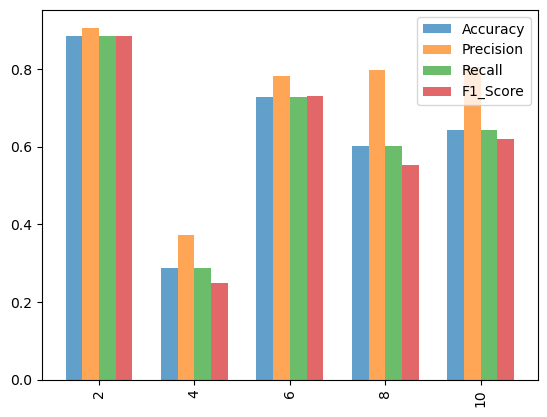

In [114]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

In [115]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

In [116]:
Client_2[1].size

10000

In [117]:
Client_2[1]

array([3, 8, 7, ..., 1, 4, 2], dtype=uint8)

In [118]:
Client_2[1][:2000] = 4

In [119]:
Client_2[1]

array([4, 4, 4, ..., 1, 4, 2], dtype=uint8)

In [120]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [121]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5200 - accuracy: 0.8560
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.2422 - accuracy: 0.9304
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1777 - accuracy: 0.9501
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1340 - accuracy: 0.9606
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1047 - accuracy: 0.9714
Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 2.3213 - accuracy: 0.1038
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2914 - accuracy: 0.1289
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2736 - accuracy: 0.1450
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2538 - accuracy: 0.1582
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2260 - accuracy: 0.1753
Epoch 1/5


In [122]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [123]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.9614 - accuracy: 0.7748 - 653ms/epoch - 2ms/step
Test accuracy: 0.7748000025749207
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.7748
Precision test set:  0.8215987617118128
Recall test set:  0.7748
F-score test set:  0.7674942733055875
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       980
           1       0.89      0.98      0.93      1135
           2       0.80      0.72      0.76      1032
           3       0.86      0.75      0.80      1010
           4       0.92      0.62      0.74       982
           5       0.48      0.87      0.62       892
           6       0.94      0.80      0.86       958
           7       0.78      0.91      0.84      1028
           8       0.93      0.26      0.41       974
           9       0.62      0.90      0.74      1009

    accuracy                           0.77     10000
   macro avg       0.82      0.77      0.76    

In [124]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [125]:
test_accuracy_dishonest.append(test_accuracy[2])
test_precision_dishonest.append(test_precision[2])
test_recall_dishonest.append(test_recall[2])
test_f1_score_dishonest.append(test_f1_score[2])

test_accuracy_dishonest.append(0.7197999954223633)
test_precision_dishonest.append(0.7649681801937827)
test_recall_dishonest.append(0.7198)
test_f1_score_dishonest.append(0.7079021148713025)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.7271999716758728, 0.7197999954223633]
[0.7834205071021751, 0.7649681801937827]
[0.7272, 0.7198]
[0.7308748558259915, 0.7079021148713025]


In [126]:
### Plot the model's performance for the 6 clients, one of them (number=2) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['All are honest', '#2 is dishonest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.7271999716758728, 0.7197999954223633], [0.7834205071021751, 0.7649681801937827], [0.7272, 0.7198], [0.7308748558259915, 0.7079021148713025]]


,Accuracy,Precision,Recall,F1_Score
All are honest,0.7272,0.783421,0.7272,0.730875
#2 is dishonest,0.7198,0.764968,0.7198,0.707902


<Axes: >

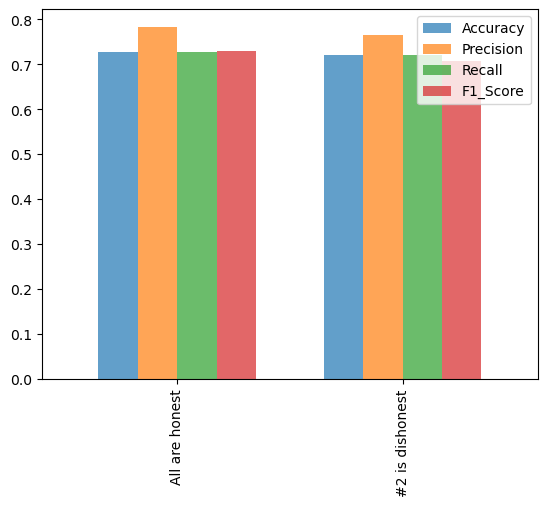

In [127]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)